#Proposta:

Se mudarmos o peso do adjetivo pleasant / unpleasant na geração das imagens, de que modo a complexidade da imagem muda? Podemos testar isso com um subconjunto das imagens geradas?

Sugestão: sortear uma meia dúzia de imagens e gerar novamente mudando o peso do adjetivo. Como fica o gráfico peso vs complexidade? Sugestão 2: normalizar pela complexidade a peso 1 que é o caso original.

Hipótese minha: se aumentar o peso, o efeito aumenta --> ou seja, a complexidade aumentará se aumentar o peso de pleasant, diminuirá se diminuir o peso de pleasant , e vice-versa em relação ao peso de unpleasant.

E se pusermos as 2 palavras cada qual com um peso diferente? Conseguiríamos modular "continuamente" o efeito de cada uma delas, modificando individualmente seus pesos?

#Referencias:

- https://arxiv.org/pdf/2308.12059
- https://huggingface.co/docs/diffusers/using-diffusers/weighted_prompts


##Dúvidas:
- Entender o comportamento dos pesos altos


In [ ]:
!pip install diffusers
!pip install torch torchvision
!pip install accelerate
!pip install compel --upgrade

In [ ]:
from diffusers import StableDiffusionPipeline, UniPCMultistepScheduler
import torch
import torchvision
from torchvision.utils import save_image
import os
from compel import Compel
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
'''
def compress(original, compressed):
    imagem_original = Image.open(original)
    imagem_original.save(compressed, optimize=True)
'''

'\ndef compress(original, compressed):\n    imagem_original = Image.open(original)\n    imagem_original.save(compressed, optimize=True)\n'

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

tamanho:498445 bytes


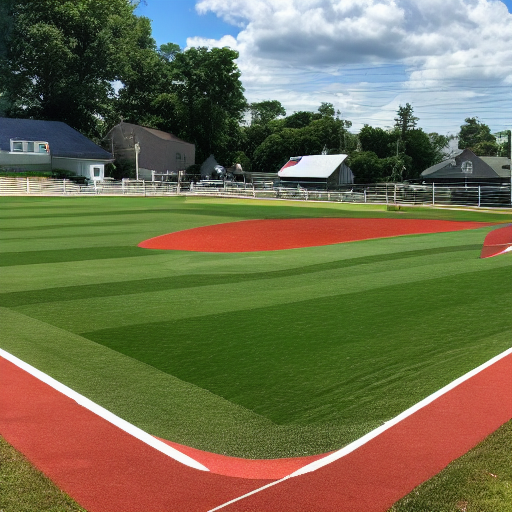

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", use_safetensors=True)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

compel_proc = Compel(tokenizer=pipe.tokenizer, text_encoder=pipe.text_encoder)

prompt = "pleasant+ field"

prompt_embeds = compel_proc(prompt)
generator = torch.manual_seed(14)

image = pipe(prompt_embeds=prompt_embeds, generator=generator, num_inference_steps=20).images[0]

file_path = "generated_image0.png"
image.save(file_path, optimize=True)

print(f"tamanho:{os.path.getsize(file_path)} bytes")
image

In [ ]:
image_size = [[] for _ in range(6)]

for i in range(0, 6):

  prompt = ["pleasant+ field", "pleasant++ field", "pleasant+++ field", "pleasant++++ field", "pleasant+++++ field", "pleasant++++++ field"]

  prompt_embeds = compel_proc(prompt[i])
  generator = torch.manual_seed(14)

  image = pipe(prompt_embeds=prompt_embeds, generator=generator, num_inference_steps=20).images[0]

  file_path = f"generated_image{i+1}.png"
  image.save(file_path, optimize=True)

  image_size[i].append(os.path.getsize(file_path))

print(image_size)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[[498445], [496271], [500939], [505515], [506898], [511258]]


#Plotando o gráfico

Peso x Complexidade (numero de bytes)

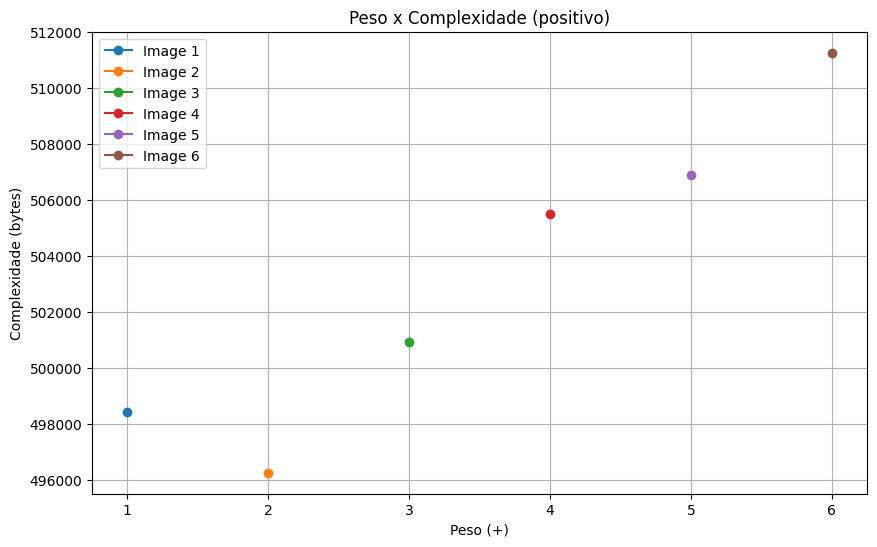

In [ ]:
#Adicionar a regressão linear

pesos = list(range(1, 7))

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(pesos[i], image_size[i][0], marker='o', label=f'Image {i+1}')

plt.title('Peso x Complexidade (positivo)')
plt.xlabel('Peso (+)')
plt.ylabel('Complexidade (bytes)')
plt.xticks(range(1, 7))
plt.legend()
plt.grid(True)
plt.show()


#Pesos Negativos

In [ ]:
image_size_neg = [[] for _ in range(6)]

for i in range(0, 6):

  prompt = ["pleasant- field", "pleasant-- field", "pleasant--- field", "pleasant---- field", "pleasant----- field", "pleasant------ field"]

  prompt_embeds = compel_proc(prompt[i])
  generator = torch.manual_seed(14)

  image = pipe(prompt_embeds=prompt_embeds, generator=generator, num_inference_steps=20).images[0]

  file_path = f"generated_image_neg{i+1}.png"
  image.save(file_path, optimize=True)

  image_size_neg[i].append(os.path.getsize(file_path))

print(image_size_neg)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[[485659], [475389], [478358], [484066], [493806], [499559]]


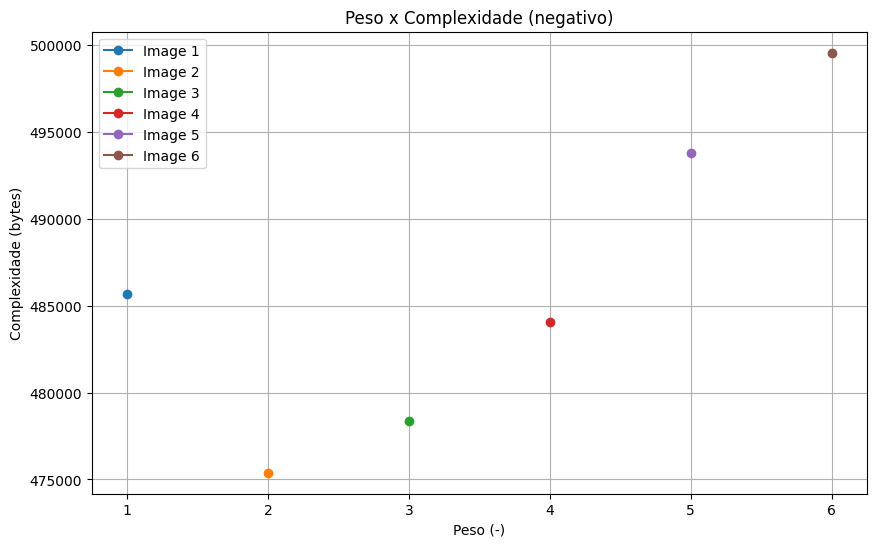

In [ ]:
#Adicionar a regressão linear

pesos = list(range(1, 7))

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(pesos[i], image_size_neg[i][0], marker='o', label=f'Image {i+1}')

plt.title('Peso x Complexidade (negativo)')
plt.xlabel('Peso (-)')
plt.ylabel('Complexidade (bytes)')
plt.xticks(range(1, 7))
plt.legend()
plt.grid(True)
plt.show()

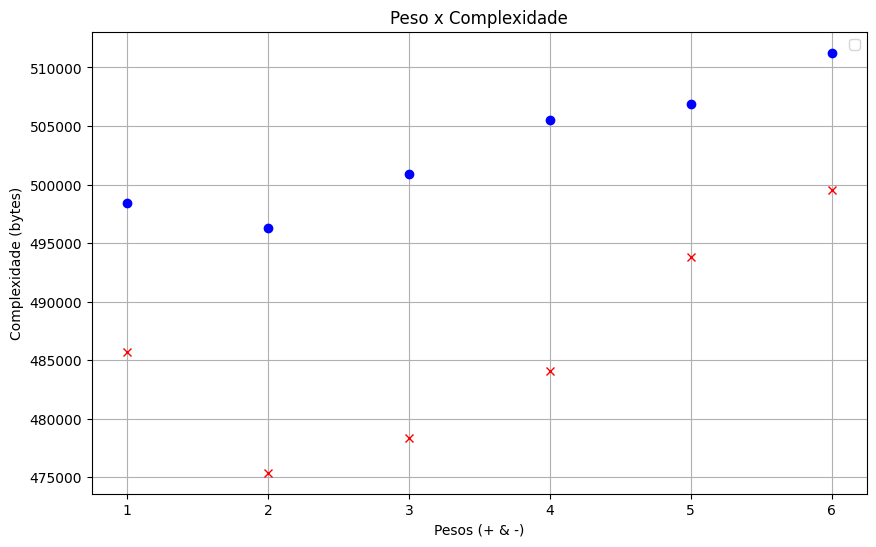

In [ ]:
#Adicionar as duas retas y= ax + b
#Comparar o coeficiente angular

pesos = list(range(1, 7))

plt.figure(figsize=(10, 6))

for i in range(6):
    plt.plot(pesos[i], image_size[i][0], marker='o', color='blue')

for i in range(6):
    plt.plot(pesos[i], image_size_neg[i][0], marker='x', color='red')

plt.title('Peso x Complexidade')
plt.xlabel('Pesos (+ & -)')
plt.ylabel('Complexidade (bytes)')
plt.xticks(range(1, 7))
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Corrigir excesso de imagens NSFW

image_size_unp = [[] for _ in range(6)]

for i in range(0, 6):

  prompt = ["unpleasant+ field", "unpleasant++ field", "unpleasant+++ field", "unpleasant++++ field", "unpleasant+++++ field", "unpleasant++++++ field"]

  prompt_embeds = compel_proc(prompt[i])
  generator = torch.manual_seed(1)

  image = pipe(prompt_embeds=prompt_embeds, generator=generator, num_inference_steps=20).images[0]

  file_path = f"generated_image_unp+{i+1}.png"
  image.save(file_path, optimize=True)

  image_size_unp[i].append(os.path.getsize(file_path))

print(image_size_unp)

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


[[842], [842], [842], [842], [842], [842]]


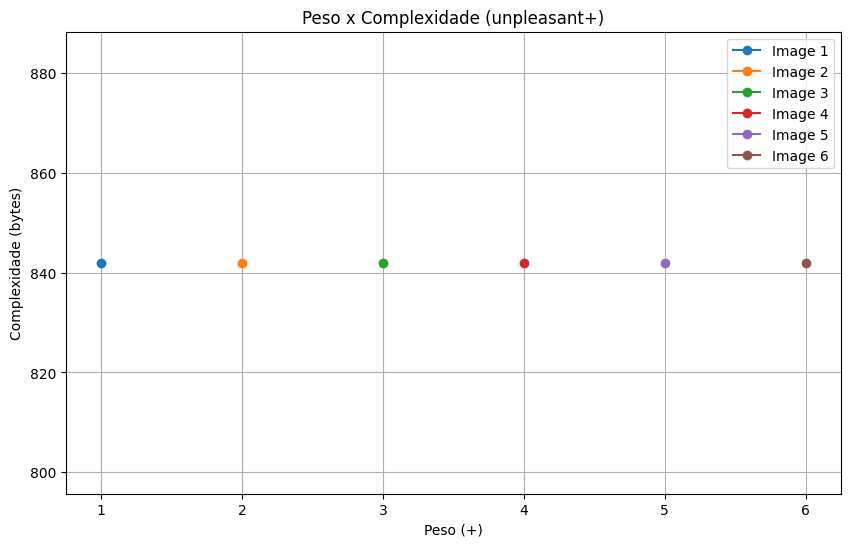

In [ ]:
pesos = list(range(1, 7))

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(pesos[i], image_size_unp[i][0], marker='o', label=f'Image {i+1}')

plt.title('Peso x Complexidade (unpleasant+)')
plt.xlabel('Peso (+)')
plt.ylabel('Complexidade (bytes)')
plt.xticks(range(1, 7))
plt.legend()
plt.grid(True)
plt.show()

Erros de NSFW, por isso o gráfico não segue a lineariedade padrão

In [ ]:
#Corrigir excesso de imagens NSFW

image_size_unp_neg = [[] for _ in range(6)]

for i in range(0, 6):

  prompt = ["unpleasant- field", "unpleasant-- field", "unpleasant--- field", "unpleasant---- field", "unpleasant----- field", "unpleasant------ field"]

  prompt_embeds = compel_proc(prompt[i])
  generator = torch.manual_seed(14)

  image = pipe(prompt_embeds=prompt_embeds, generator=generator, num_inference_steps=20).images[0]

  file_path = f"generated_image_unp-{i+1}.png"
  image.save(file_path, optimize=True)

  image_size_unp_neg[i].append(os.path.getsize(file_path))

print(image_size_unp_neg)

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[[842], [455177], [467335], [842], [535050], [622129]]


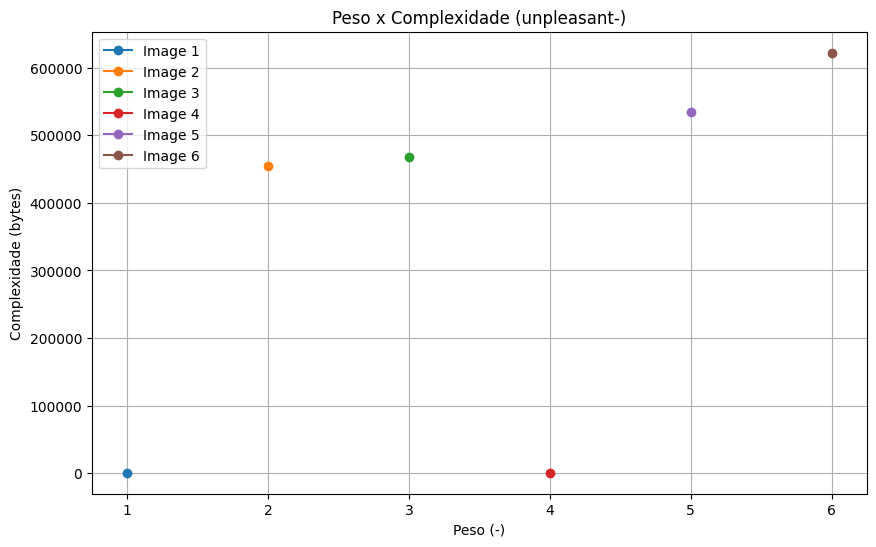

In [ ]:
pesos = list(range(1, 7))

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(pesos[i], image_size_unp_neg[i][0], marker='o', label=f'Image {i+1}')

plt.title('Peso x Complexidade (unpleasant-)')
plt.xlabel('Peso (-)')
plt.ylabel('Complexidade (bytes)')
plt.xticks(range(1, 7))
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
prompt = []
size = []

for i in range(20):
    if i == 0:
        prompt.append("pleasant landscape")
    else:
        prompt.append("pleasant" + "+" * i + " landscape")

for i in range(20):

  prompt_embeds = compel_proc(prompt[i])
  generator = torch.manual_seed(14)

  image = pipe(prompt_embeds=prompt_embeds, generator=generator, num_inference_steps=20).images[0]

  file_path = f"image_{i+1}.png"
  image.save(file_path, optimize=True)

  size.append(os.path.getsize(file_path))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

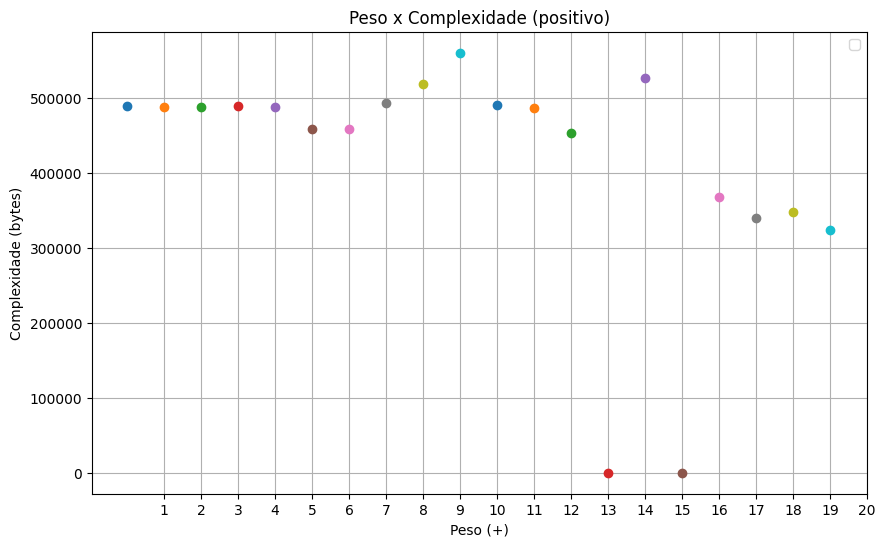

In [ ]:
#Entender o porquê de não haver crescimento linear
#Entender o porquê de parecer não ter completado a difusão

pesos = list(range(20))

plt.figure(figsize=(10, 6))
for i in range(20):
    plt.plot(pesos[i], size[i], marker='o')

plt.title('Peso x Complexidade (positivo)')
plt.xlabel('Peso (+)')
plt.ylabel('Complexidade (bytes)')
plt.xticks(range(1, 21))
plt.legend()
plt.grid(True)
plt.show()

##Hipótese minha:

  O uso dos pesos está proporcionalmente relacionando à complexidade. Pode ser que, para complexidades altas, seja necessário um número maior de passos de inferência. (uso atual= 20)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

tamanho:394094 bytes


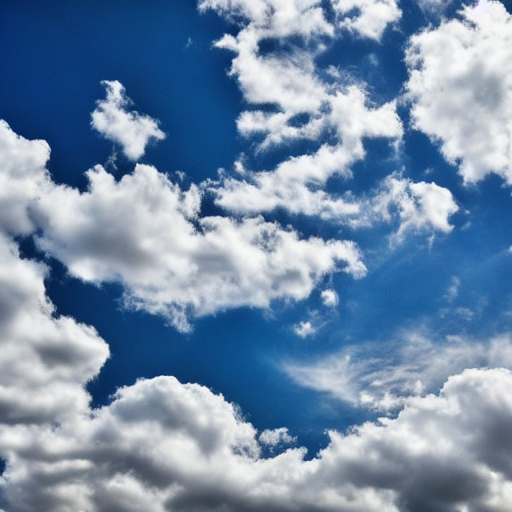

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", use_safetensors=True)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

compel_proc = Compel(tokenizer=pipe.tokenizer, text_encoder=pipe.text_encoder)

prompt = "cloudy--- sky+++"

prompt_embeds = compel_proc(prompt)
generator = torch.manual_seed(14)

image = pipe(prompt_embeds=prompt_embeds, generator=generator, num_inference_steps=20).images[0]

file_path = "circle.png"
image.save(file_path, optimize=True)

print(f"tamanho:{os.path.getsize(file_path)} bytes")
image

##- Estudar uso da biblitoeca Pillow e Pil
##- Analisar a cor da bola vermelha, para cada peso analisar a diferença do tom e plotar o gráfico.
##- Comparar com os gráficos de complexidade
##- 12 imagens (6+ e 6-)